# 주택 가격 예측
- 데이터: 주택별 건축 연도, 설비, 넓이 등 설명 변수 79개와 목적변수인 주택 가격
- 예측 정확도 평가: 평균 제곱 오차(RMSE)
- 연속적인 값을 예측하는 회귀 분석 사용

분류: 클래스 두 개 혹은 여러개로 분류<br>
회귀: 연속된 값을 예측

값에 로그를 취해서 차이를 작게 만들어 특정 데이터가 평가에 영향을 미치는 정도를 줄인다. 

## 1. 데이터 분석 준비
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

#### 디렉터리 구성
C:\kaggle\house-prices\data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use('ggplot')

In [2]:
import random
np.random.seed(1234)
random.seed(1234)

In [3]:
train_df=pd.read_csv('C:/kaggle/house-prices/data/train.csv')
test_df=pd.read_csv('C:/kaggle/house-prices/data/test.csv')
submission=pd.read_csv('C:/kaggle/house-prices/data/sample_submission.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 벤치마크용 베이스라인 작성
#### 학습 데이터의 변수 유형 확인하기
lightgbm에서 읽을 수 있는 것은 int, float, bool뿐이다 

In [5]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
train_df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### 학습 데이터와 테스트 데이터를 합해서 전처리하기
예측을 실행할 때는 SalePrice 값 유무를 사용해서 학습 데이터와 테스트 데이터로 분할한다.

In [7]:
#합칠때 인덱스 새로 매기기
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
all_df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [8]:
all_df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

#### 카테고리 변수를 수치로 변환하기

In [9]:
from sklearn.preprocessing import LabelEncoder
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [10]:
all_df['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

#### 결측치를 수치로 변환하기

In [11]:
for cat in categories:
    #수치로 변환
    le=LabelEncoder()
    print(cat)
    
    all_df[cat].fillna('missing',inplace=True)
    le=le.fit(all_df[cat])
    all_df[cat]=le.transform(all_df[cat])
    #카테고리 변수임을 명시
    all_df[cat]=all_df[cat].astype('category')

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [12]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


#### train_df와 test_df로 되돌리기

In [13]:
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]

#### LightGBM으로 데이터 읽기

In [14]:
import lightgbm as lgb

In [15]:
#교차검증
from sklearn.model_selection import KFold
folds=3
kf=KFold(n_splits=folds)

In [16]:
#하이퍼파라미터 설정
lgbm_params={
    'objective':'regression',
    'random_seed':1234
}

In [17]:
train_X=train_df_le.drop(['SalePrice','Id'],axis=1)
train_Y=train_df_le['SalePrice']

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

In [20]:
sum(rmses)/len(rmses)

0.13697846250952908

In [21]:
actual_pred_df=pd.DataFrame({
    'actual':train_Y,
    'pred':oof
})

<AxesSubplot:>

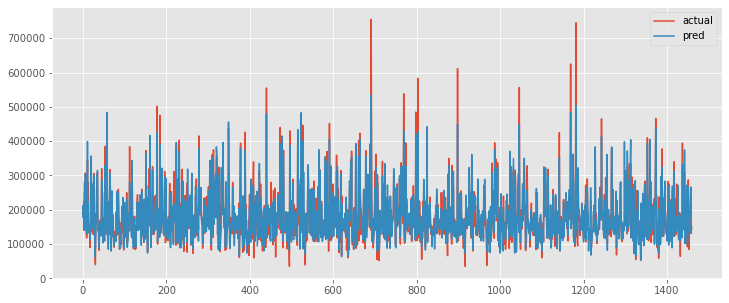

In [22]:
actual_pred_df.plot(figsize=(12,5))

#### 각 변수의 중요도 확인

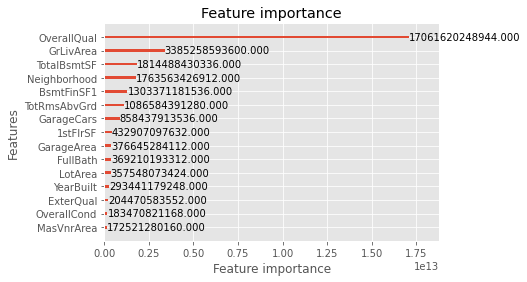

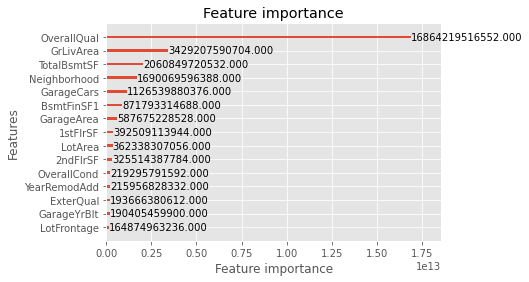

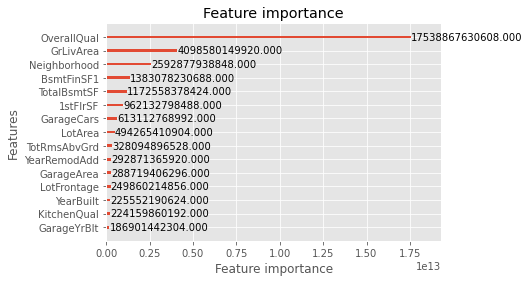

In [23]:
#표시될 변수의 수 제한
for model in models:
    lgb.plot_importance(model,importance_type='gain',max_num_features=15)

## 3. 목적 변수의 전처리:목적 변수의 분포 확인
#### SalePrice 데이터의 분포 확인

In [25]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:ylabel='Frequency'>

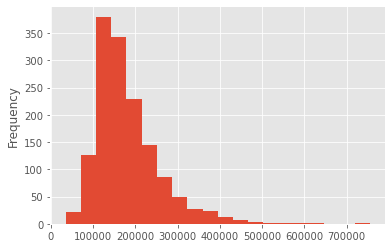

In [26]:
train_df['SalePrice'].plot.hist(bins=20)

푸아송 분포
- 잘 일어나지 않는 사건이 실제로 일어날 확률의 분포를 나타날때 이용
- 왼쪽으로 치우친다

In [27]:
#로그화
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot:ylabel='Frequency'>

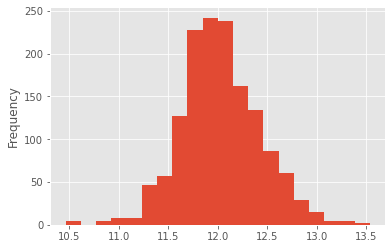

In [28]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [29]:
pd.options.mode.chained_assignment=None
train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])

In [32]:
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

In [33]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0435757
[20]	valid_0's l2: 0.0223987
[30]	valid_0's l2: 0.0176962
[40]	valid_0's l2: 0.0164304
[50]	valid_0's l2: 0.0161943
[60]	valid_0's l2: 0.0161858
[70]	valid_0's l2: 0.0161666
[80]	valid_0's l2: 0.0161769
[90]	valid_0's l2: 0.0162121
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0161129
0.12693572281592597
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0480056
[20]	valid_0's l2: 0.0274907
[30]	valid_0's l2: 0.022779
[40]	valid_0's l2: 0.0214744
[50]	valid_0's l2: 0.0209095
[60]	valid_0's l2: 0.0205922
[70]	valid_0's l2: 0.0204381
[80]	valid_0's l2: 0.0203135
[90]	valid_0's l2: 0.020318
[100]	valid_0's l2: 0.0202246
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0202246
0.1422133338842566
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0388654
[20]	valid_0's l2: 0.0209198
[30]	valid_0's l2: 0.0176337

In [34]:
sum(rmses)/len(rmses)

0.13284034805621694

정확도가 높아졌다.

## 4. 설명 변수의 전처리: 결측치 확인

In [35]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [36]:
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [37]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

In [40]:
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [41]:
#결과값 있으면 1 없으면 0
all_df.loc[~all_df['PoolQC'].isnull(),'PoolQC']=1
all_df.loc[all_df['PoolQC'].isnull(),'PoolQC']=0

In [42]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [43]:
#MiscFeature, Alley도 똑같이 처리
all_df.loc[~all_df['MiscFeature'].isnull(),'MiscFeature']=1
all_df.loc[all_df['MiscFeature'].isnull(),'MiscFeature']=0

all_df.loc[~all_df['Alley'].isnull(),'Alley']=1
all_df.loc[all_df['Alley'].isnull(),'Alley']=0

In [48]:
#for문으로 편하게 작업
HighFacility_col=['PoolQC','MiscFeature','Alley']
for col in HighFacility_col:
    if all_df[col].dtype=='object':
        if len(all_df[all_df[col].isnull()])>0:
            all_df.loc[~all_df[col].isnull(),col]=1
            all_df.loc[all_df[col].isnull(),col]=0

In [49]:
#새로운 고급 설비 변수 생성
all_df['hasHighFacility']=all_df['PoolQC']+all_df['MiscFeature']+all_df['Alley']

In [50]:
all_df['hasHighFacility']=all_df['hasHighFacility'].astype(int)

In [51]:
all_df['hasHighFacility'].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [52]:
all_df=all_df.drop(['PoolQC','MiscFeature','Alley'],axis=1)

## 5.이상치 제외
크기가 너무 넓거나 방 개수가 너무 많은 주택 등 일반적인 경향과 다른 데이터가 있는지 확인한다.
#### 이상치란
- 통상적인 경향과 다른 값
- 이상치가 존재하면 예측 정확도가 떨어진다